# GAN - FFHQ - 128×128 px
Generative Adversarial Network for generating images of faces from Flickr-Faces-HQ database - code for analyzing images.

Developed by Daniel Konečný

## Initialize
Defines the basic libraries and initializes global variables needed in all codes. Connects the code to data source - Google Drive.

In [0]:
import numpy as np
import tensorflow as tf
import json
import math
from tensorflow.keras.models import load_model
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import joblib

import pandas as pd
import glob
import scipy
from scipy import stats
from scipy.stats import t
from scipy.stats import f

dataset = 'ffhq'
x_dimension = 128
y_dimension = 128
note = ''

project_name = f'{dataset}{x_dimension}x{y_dimension}{note}'
project_path = '/'
feature_path = f'{project_path}features/'
image_path = f'{project_path}images/'
latent_path = f'{project_path}analysis/'
model_path = f'{project_path}models/'

latent_dimension = 256

## Analyzing functions
General functions necessary for analyzing, initialize before.

In [0]:
feature_dict = {
    'hair_color': ['other', 'blonde', 'brown', 'black', 'gray']
}

# Other features:
# 'glasses': ['other', 'no', 'yes'],
# 'hair_color': ['other', 'blonde', 'brown', 'black', 'gray']
# 'gender': ['other', 'male', 'female'],
# 'skin_color': ['other', 'white', 'tan', 'brown', 'black'],


def get_latent(sample_count=1):
	latents = np.empty((sample_count, latent_dimension))

	for latents_index in range(sample_count):
		randoms = np.random.normal(0, 1, latent_dimension)
		normalizer = np.sum(randoms**2)**0.5
		latent = randoms/normalizer
		latents[latents_index] = latent
	
	return latents


def save_latent(latent, index, feature_name):
    print(f'Saving latent number {index}...')
    np.savetxt(f'{feature_path}{feature_name}/{project_name}_latent{index:03d}.csv', latent,
            delimiter=',')


def get_images(epoch_number, latent):
    print(f'Creating images from epoch {epoch_number}...')
    model = \
    load_model(f'{model_path}{project_name}_generator{epoch_number:04d}.h5',
               compile=False)
    images = model.predict(latent)
    return images


def save_image(image_numpy, index, feature_name):
    print(f'Saving image number {index}...')
    image_numpy = np.squeeze(image_numpy, axis=0)
    image_numpy *= 255.0
    image_numpy = image_numpy.astype('uint8')
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(f'{feature_path}{feature_name}/{project_name}_image{index:03d}.png')
    display(image_pil)


def save_image_with_features(image_numpy, index, features):
    image_numpy = np.squeeze(image_numpy, axis=0)
    image_numpy *= 255.0
    image_numpy = image_numpy.astype('uint8')
    image_pil = Image.fromarray(image_numpy)

    features_string = ""

    for feature in features:
        features_string += '_' + feature["feature"]
        features_string += '_' + feature["value"]

    print(f'Saving image with feature {features_string}')
    image_pil.save(f'{image_path}{project_name}{features_string}{index:04d}.png')


def set_features(index, feature_name):
    features = {}
    unrecognizable_char = '`'

    print('What are the features? 0 for other, ` for unrecognizable')

    for feature_key in feature_dict:
        print(f'{feature_key}:', end=' ')
        for feature_index in range(1, len(feature_dict[feature_key])):
            print(f'{feature_index}-{feature_dict[feature_key][feature_index]}',
                  end=' ')
        feature_input = input()
        if feature_input == unrecognizable_char:
            return False
        features[feature_key] = feature_dict[feature_key][int(feature_input)]

    with open(f'{feature_path}{feature_name}/{project_name}_features{index:03d}.json', 'w') \
    as feature_file:
        json.dump(features, feature_file)
    
    return True


def test_feature(lda, value, strength, latent):
    y_probability = lda.predict_proba([latent])

    # Compare probability of wanted value of feature with other values.
    for index in range(len(y_probability[0])):
        # Ignore the wanted value of feature itself.
        if index == value:
            continue
        
        if y_probability[0][value] < strength*y_probability[0][index]:
            return False
    
    #print(f'{y_probability[0][value]} - ', end='')

    return True


def test_latent(features, latent):
    for feature in features:
        lda = joblib.load(f'{latent_path}{project_name}_lda_{feature["feature"]}.joblib')
        le = joblib.load(f'{latent_path}{project_name}_le_{feature["feature"]}.joblib')
        value = le.transform([feature['value']])[0]
        strength = feature['strength']

        if not test_feature(lda, value, strength, latent):
            return False
        
        #print(f'{feature["feature"]} - {feature["value"]}')

    return True


def get_latent_with_features(features):
    found = None

    while found is None:
        latents = get_latent(1000)

        for latent in latents:
            if test_latent(features, latent):
                found = latent
                break

    return found.reshape(1, latent_dimension)

## Classify images
1. Generate and save new latent.
2. Generate image from latent, save and display it.
3. Classify image's features and save them.

In [0]:
epoch_number = 700
first_sample = 500
sample_count = 500

feature_name = 'hair_color'

for sample_index in range(first_sample, sample_count):
    unrecognizable_image = False
    while not unrecognizable_image:
        latent = get_latent()
        save_latent(latent, sample_index, feature_name)
        image = get_images(epoch_number, latent)
        save_image(image, sample_index, feature_name)
        unrecognizable_image = set_features(sample_index, feature_name)

## Load and Preprocess Samples
Load and preprocess samples for analysis. Set the feature name and number of samples and launch.

In [0]:
from sklearn import preprocessing

# Choose feature name: glasses or hair_color.
feature_name = 'hair_color'

# Sample count for both features is 500, do not change.
sample_count = 500

samples = []
latents = np.empty((sample_count, latent_dimension))
labels = []


print('Loading samples...')
for sample_index in range(sample_count):
    latent = np.loadtxt(f'{feature_path}{feature_name}/{project_name}_latent{sample_index:03d}.csv',
                     delimiter=',')

    with open(f'{feature_path}{feature_name}/{project_name}_features{sample_index:03d}.json') \
    as feature_file:
        features = json.load(feature_file)

    sample = {
        'latent': latent,
        'features': features
    }
    samples.append(sample)

    if (sample_index + 1) % 100 == 0:
        print(f'Sample {sample_index + 1} loaded.')

print('\nPreparing samples...')
for sample_index in range(sample_count):
    latents[sample_index] = samples[sample_index]['latent']
    labels.append(samples[sample_index]['features'][feature_name])

print('Converting string labels to integers...')
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)

# Uncomment only when loading new data.
#joblib.dump(label_encoder, f'{latent_path}{project_name}_le_{feature_name}.joblib')
#print('Label Encoder model saved.')

classes = np.array(label_encoder.transform(labels))

assert latents.shape[0] == classes.shape[0]

class_count = len(label_encoder.classes_)
original_sample_count = latents.shape[0]
original_dimension_count = latents.shape[1]

print(f'\nSamples: {original_sample_count}')
print(f'Dimensions: {original_dimension_count}')

sample_distribution = [0] * class_count
for sample_index in range(latents.shape[0]):
    sample_distribution[classes[sample_index]] += 1

print(f'\nClasses ({class_count}):')
for label_index in range(class_count):
    print(f'{label_index}: {label_encoder.inverse_transform([label_index])[0]}' \
          f' - {100/(original_sample_count/sample_distribution[label_index]):.1f} %')

Loading samples...
Sample 100 loaded.
Sample 200 loaded.
Sample 300 loaded.
Sample 400 loaded.
Sample 500 loaded.

Preparing samples...
Converting string labels to integers...
Label Encoder model saved.

Samples: 500
Dimensions: 256

Classes (4):
0: black - 54.0 %
1: blonde - 5.8 %
2: brown - 28.2 %
3: gray - 12.0 %


## Student's t-test Dimension Analysis
Analysis of single dimensions.

### Preprocess data to Pandas DataFrame and DataFile
Load data to a Pandas DataFrame for easier processing.

In [0]:
latents_pd = pd.DataFrame(latents)
classes_pd = pd.DataFrame(classes, columns = ['class'])
data_pd = pd.concat([classes_pd, latents_pd], axis=1)

NV1 = data_pd.loc[data_pd['class']==0]
NV2 = data_pd.loc[data_pd['class']==1]

### Initial assumptions about data
- Samples are independent.
- Samples come from Normal (Gaussian) Distribution $\mathcal{N}(\mu, \sigma^2)$
- Variance of samples is equal.

According to the following computation, these criteria are met.

In [0]:
alpha = 0.01

print('Test if samples come from Normal Distribution.')

print('Class 0 - without glasses.')
for dimension_index in range(latent_dimension):
    _, p_value = stats.normaltest(NV1[dimension_index])
    if p_value < alpha:
        print(f'- Dimension {dimension_index+1:03d} is abnormal (p = {p_value:.6f}).')

print('Class 1 - with glasses.')
for dimension_index in range(latent_dimension):
    _, p_value = stats.normaltest(NV2[dimension_index])
    if p_value < alpha:
        print(f'- Dimension {dimension_index+1:03d} is abnormal (p = {p_value:.6f}).')

print('\nTest if samples have the same variance.')
for dimension_index in range(latent_dimension):
    _, p_value = stats.levene(NV1[dimension_index], NV2[dimension_index], center='mean')
    if p_value < alpha:
        print(f'- Dimension {dimension_index+1:03d} has different variance (p = {p_value:.6f}).')

Test if samples come from Normal Distribution.
Class 0 - without glasses.
- Dimension 013 is abnormal (p = 0.003536).
- Dimension 042 is abnormal (p = 0.007527).
- Dimension 206 is abnormal (p = 0.005913).
Class 1 - with glasses.
- Dimension 058 is abnormal (p = 0.008575).
- Dimension 086 is abnormal (p = 0.006904).
- Dimension 094 is abnormal (p = 0.009086).
- Dimension 099 is abnormal (p = 0.007085).

Test if samples have the same variance.
- Dimension 164 has different variance (p = 0.009183).
- Dimension 171 has different variance (p = 0.007824).
- Dimension 220 has different variance (p = 0.000560).


### Compute Student's t-test



Statistical difference between classes can be determined by the difference between means of both classes.

Null Hypothesis $H_0: \mu_1 - \mu_2 = 0$

Alternative Hypothesis $H_1: \mu_1 - \mu_2 \neq 0$ 

Student's t-test will be used to determine whether the Null Hypothesis holds.

Test criteria is:
$$t=\frac{M_1-M_2}{S\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}},$$
where
- $M_1$ and $M_2$ are means of the data,
- $n_1$ and $n_2$ are sizes of samples,
- $S$ is weighted average of standard deviations $S_1^2$ a $S_2^2$:
$$ S^2 = \frac{(n_1-1)S_1^2 + (n_2-1)S_2^2}{n_1 + n_2 - 2}.$$

Significance level $\alpha$, which is probability of Type I error, is set and critical region is computed:
$$W = (-\infty; -t_{1-\alpha/2}(n_1 + n_2 - 2) \rangle \cup \langle t_{1-\alpha/2}(n_1 + n_2 - 2); \infty).$$

If test criteria $t0$ belongs to critical region, $H_0$ is rejected on significance level $\alpha$, and $H_1$ holds.

Dimensions, for which the Null Hypothesis gets rejected, affect the given feature (glasses presence).

In [0]:
dimensions = [i for i in range(latent_dimension)]
M1 = NV1[dimensions].mean()
M2 = NV2[dimensions].mean()

n1 = NV1.shape[0]
n2 = NV2.shape[0]

S1 = NV1[dimensions].var()
S2 = NV2[dimensions].var()

S = []
for dimension_index in range(latent_dimension):
    S.append(((n1-1)*S1[dimension_index] + (n2-1)*S2[dimension_index]) /
             (n1+n2-2))

t0 = []
for dimension_index in range(latent_dimension):
    t0.append((M1[dimension_index] - M2[dimension_index]) /
              (math.sqrt(S[dimension_index])*math.sqrt((1/n1)+(1/n2))))

alpha = 0.01
W = stats.t.ppf((1-alpha/2), (n1+n2-2))

potential_dimensions = []
for dimension_index in range(latent_dimension):
    if abs(t0[dimension_index]) >= W:
        potential_dimensions.append(dimension_index)

print(f'Dimension that could potentially serve for separating feature classes:'\
      f' {[dimension+1 for dimension in potential_dimensions]}')

Dimension that could potentially serve for separating feature classes: [20, 25, 30, 46, 70, 110, 143, 144, 148, 156, 160, 171, 206, 212, 216, 230, 237, 248, 250]


### Histograms of dimension affecting the feature
From these histograms, it is clear that even these dimensions cannot be used to separature classes of given feature (glasses presence).

In [0]:
for dimension_index in potential_dimensions:
    plt.hist(NV1[dimension_index], alpha = 0.5, label='Without Glasses')
    plt.hist(NV2[dimension_index], alpha = 0.5, label='With Glasses')
    plt.legend(loc='upper right')
    plt.title(f'Dimension: {dimension_index+1}')
    plt.show()

#### Obtain the histogram information for LaTeX

In [0]:
# Create histogram intervals.
limits = [-1, 1]
step = 0.025
intervals = np.empty((int((limits[1]-limits[0])/step)+1))
for interval_index in range(len(intervals)):
    intervals[interval_index] = limits[0]+interval_index*step

# Load data in given dimensions.
dimensions = 148, 237
data = []
for dimension in dimensions:
    data.append(NV1[dimension-1])
    data.append(NV2[dimension-1])

# Count samples in intervals.
counts = np.zeros((len(data), len(intervals)))
for j in range(len(data)):
    for i in data[j]:
        for interval_index in range(len(intervals)):
            if i < intervals[interval_index]:
                counts[j][interval_index] += 1
                break

# Display in format for LaTeX histogram.
for data_index in range(len(data)):
    print(f'Dimension: {dimensions[data_index//2]}')
    print(f'Label: {data_index%2}')
    for interval_index in range(len(counts[data_index])):
        if int(counts[data_index][interval_index]) > 0:
            print(f'({intervals[interval_index]:.03f}, {int(counts[data_index][interval_index])})', end=' ')
    print('\n')

Dimension: 148
Label: 0
(-0.150, 2) (-0.125, 2) (-0.100, 10) (-0.075, 27) (-0.050, 31) (-0.025, 51) (0.000, 58) (0.025, 63) (0.050, 64) (0.075, 32) (0.100, 30) (0.125, 15) (0.150, 6) (0.175, 1) (0.200, 2) (0.225, 2) 

Dimension: 148
Label: 1
(-0.150, 2) (-0.125, 4) (-0.100, 6) (-0.075, 10) (-0.050, 16) (-0.025, 21) (0.000, 13) (0.025, 12) (0.050, 7) (0.075, 7) (0.100, 4) (0.150, 2) 

Dimension: 237
Label: 0
(-0.225, 1) (-0.150, 1) (-0.125, 7) (-0.100, 16) (-0.075, 32) (-0.050, 33) (-0.025, 52) (0.000, 57) (0.025, 62) (0.050, 43) (0.075, 45) (0.100, 23) (0.125, 14) (0.150, 7) (0.175, 3) 

Dimension: 237
Label: 1
(-0.125, 1) (-0.100, 2) (-0.075, 4) (-0.050, 8) (-0.025, 12) (0.000, 12) (0.025, 14) (0.050, 24) (0.075, 11) (0.100, 8) (0.125, 3) (0.150, 1) (0.175, 3) (0.200, 1) 



## Linear Discriminant Analysis
Analysis of the whole latent space with Linear Discriminant Analysis (LDA).

### Project the samples to a subspace
Projects the samples to a subspace with the LDA.

Linear Discrimination Analysis model saved.
Failed recognition (image indices): 128 142 179 233 239 359 438 

Class 0
(-1.110, -1.001, -0.982) (-1.982, -0.768, -0.033) (-2.329, 0.300, 0.530) (-2.579, 0.945, -0.854) (-0.406, -0.167, -2.197) (-0.964, -0.196, -2.025) (-0.542, -0.256, 0.942) (-2.418, -0.887, -0.941) (-0.827, 1.464, 0.163) (-0.899, 1.095, -1.553) (-0.865, -0.209, -0.540) (-1.891, -0.983, -0.439) (-1.278, -0.244, 0.715) (-2.515, -0.494, -0.330) (-2.095, 0.429, -0.343) (-2.797, -0.338, 0.423) (-0.157, 0.163, 0.748) (-1.717, -0.210, -1.727) (-1.741, -1.745, -0.587) (-2.437, -0.114, 1.692) (-0.860, 1.083, -0.698) (-1.777, -1.689, -1.263) (-0.775, 0.053, 1.482) (-2.684, 0.249, -2.033) (-3.598, -0.673, 1.648) (-0.467, -0.736, -0.583) (-0.685, 0.410, -0.634) (-1.906, -0.313, -0.432) (-1.237, -0.886, 0.380) (-0.796, -0.967, 0.926) (-3.969, 0.788, 1.665) (-1.772, -0.872, -0.365) (-2.599, -0.007, -1.101) (-2.652, 0.250, -3.186) (-3.631, -0.804, -0.622) (-1.326, 1.197, -0.383) (-1.847

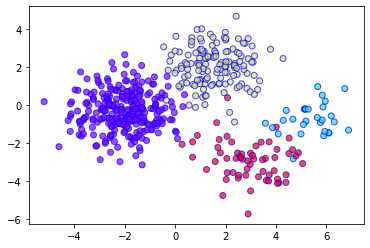

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=class_count-1)
lda.fit(latents, classes)

# Uncomment only when loading new data.
#joblib.dump(lda, f'{latent_path}{project_name}_lda_{feature_name}.joblib')
#print('Linear Discrimination Analysis model saved.')

latents_transformed = latents
latents_transformed = lda.transform(latents_transformed)
class_prediction = lda.predict(latents)

print('Failed recognition (image indices): ', end='')
for image_index in range(sample_count):
    if classes[image_index] != class_prediction[image_index]:
        print(f'{image_index}', end=' ')

class_probability = lda.decision_function(latents)

if class_count < 3:
    for class_index in range(class_count):
        print(f'\n\nClass {class_index}')
        for latent_index in range(len(latents_transformed)):
            if classes[latent_index] == class_index:
                print(f'({latents_transformed[latent_index][0]:.3f}, 0)', end=' ')


    plt.scatter(
        latents_transformed[:,0],
        latents_transformed[:,0],
        c=classes,
        cmap='rainbow',
        alpha=0.7,
        edgecolors='b'
    )

else:
    for class_index in range(class_count):
        print(f'\n\nClass {class_index}')
        for latent_index in range(len(latents_transformed)):
            if classes[latent_index] == class_index:
                print(f'({latents_transformed[latent_index][0]:.3f}, {latents_transformed[latent_index][1]:.3f}, {latents_transformed[latent_index][2]:.3f})', end=' ')

    plt.scatter(
        latents_transformed[:,0],
        latents_transformed[:,1],
        c=classes,
        cmap='rainbow',
        alpha=0.7,
        edgecolors='b'
    )

### Test LDA Classifier
Manually label images and test the success rate of the LDA classifier. Set the epoch index of the model, feature name, the number of tested samples and launch.



In [0]:
epoch_number = 700
feature_name = 'glasses'
correct = 0
total = 100

# Used just as an index of the generated image, not necessary to change.
sample_index = 998

lda = joblib.load(f'{latent_path}{project_name}_lda_{feature_name}.joblib')

for index in range(total):
    latent = get_latent()
    image = get_images(epoch_number, latent)
    save_image(image, sample_index, feature_name)

    print('Glasses: Enter-no other-yes', end=' ')
    feature_human = input()
    if feature_human == '':
        feature_human = 0
    else:
        feature_human = 1

    feature_lda = lda.predict(latent)

    if feature_human == feature_lda:
        print('Correct!')
        correct += 1

print(f'Classifier success rate is {correct/total*100} %.')

### Generate Face with Features Chosen by User
Launch to generate a face with selected features.

In [0]:
epoch_number = 700
feature_dict = {
    'hair_color': ['blonde', 'brown', 'black', 'gray'],
    'glasses': ['no', 'yes']
}
features = []

chosen_feature = '0'
while chosen_feature != '':
    print('Choose feature (or Enter to end): ', end='')
    for feature in feature_dict:
        print(f'{feature}', end=' ')
    chosen_feature = input()
    if chosen_feature == '':
        break
    print('Choose value: ', end='')
    for value in feature_dict[chosen_feature] :
        print(f'{value}', end=' ')
    chosen_value = input()
    if chosen_feature != '':
        print('Set strength: 10^', end='')
        chosen_strength = int(input())
        features.append({
            'feature': chosen_feature,
            'value': chosen_value,
            'strength': chosen_strength
        })

latent = get_latent_with_features(features)
image = get_images(epoch_number, latent)
save_image(image, 999, 'generated')

### Probability of Generating Face with Given Feature
Manually label images and test the succes rate of generating face with given features.

In [0]:
epoch_number = 700
sample_count = 10
sample_true = 0
features = [{
    'feature': 'hair_color',
    'value': 'gray',
    'strength': 1e9
}]

"""
{
    'feature': 'glasses',
    'value': 'yes',
    'strength': 1e8
}
, 
"""

print("1 for correct face, enter otherwise")

for sample_index in range(sample_count):
    latent = get_latent_with_features(features)
    image = get_images(epoch_number, latent)
    save_image(image, sample_index, 'generated')

    classification = input()
    if classification == '1':
        sample_true += 1

print(f'Probability of forced feature - {sample_true/sample_count*100:.1f} %')

### Create Set of Images with Forced Features
Set features and generate a set of images with it.

In [0]:
epoch_number = 700
sample_count = 6
features = [{
    'feature': 'glasses',
    'value': 'yes',
    'strength': 1e6
},{
    'feature': 'hair_color',
    'value': 'brown',
    'strength': 1e8
}]

for sample_index in range(sample_count):
    latent = get_latent_with_features(features)
    image = get_images(epoch_number, latent)
    save_image_with_features(image, sample_index, features)

### Choose Indices of Images with Labeled Feature
Set feature and get indices of samples with it.

In [0]:
# Choose feature name: glasses or hair_color.
feature_name = 'glasses'
feature_value = 'yes'

# Sample count for both features is 500, do not change.
sample_count = 500

indices = []

print('Loading samples...')
for sample_index in range(sample_count):
    with open(f'{feature_path}{feature_name}/{project_name}_features{sample_index:03d}.json') \
    as feature_file:
        features = json.load(feature_file)

    if features[feature_name] == feature_value:
        indices.append(sample_index)

print(f'\nIndices: {indices}')